<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S7_2_Transfer_Learning_%26_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning & Fine Tuning 

## Ce que vous apprendrez dans ce cours

Une faculté précieuse du Deep Learning est celle de pouvoir s'adapter à plusieurs situations différentes via le _Transfer Learning_. Le principe est simple, au lieu de construire une architecture de réseaux de neurones from scratch, nous allons utiliser des architectures pré-faites et pré-entrainées. Cette technique permet d'atteindre des résultats de performances _state of the art_. 

Ce cours vise donc à montrer comment effectuer du _Transfer Learning_ sur Tensorflow 2.0. Nous utiliserons ceci pour de la reconnaissance d'images sur des types de fleurs contenues dans un dossier *flower_photos*.

## Chargement du dataset & preprocessing 

### Téléchargement des images depuis des chemins

In [0]:
!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf

     |████████████████████████████████| 348.9MB 79kB/s 
     |████████████████████████████████| 3.1MB 23.7MB/s 
     |████████████████████████████████| 501kB 35.5MB/s 
  Found existing installation: tb-nightly 1.14.0a20190301
    Uninstalling tb-nightly-1.14.0a20190301:
      Successfully uninstalled tb-nightly-1.14.0a20190301
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019030115
    Uninstalling tf-estimator-nightly-1.14.0.dev2019030115:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019030115
  Found existing installation: tensorflow-gpu 2.0.0a0
    Uninstalling tensorflow-gpu-2.0.0a0:
      Successfully uninstalled tensorflow-gpu-2.0.0a0


Nous allons utiliser la méthode *get_file* du module *tf.keras.utils* pour télécharger des données publiques contenues dans Google Cloud Storage que nous stockerons ensuite dans une dossier *flower_photos*

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='/content/flower_photos.tgz', 
                                         untar=True,
                                         cache_subdir="/content")
data_root = pathlib.Path("/content/flower_photos")
print(data_root)

228818944/228813984 [==============================] - 4s 0us/step
/content/flower_photos


Dans le code du dessus,  nous spécifions les paramètres suivants : 

* `origin`: l'url vers lequel est contenu les données 
* `fname`: est le nom du fichier que vous souhaitez télécharger. Vous pouvez aussi spécifier le chemin dans lequel le fichier doit être stocké.
* `untar`: Ceci permet de décompresser les fichiers automatiquement 
* `cache_subdir`: Cela spécifier le sous-dossier dans lequel doit être contenu les données décompressées 

Regardons maintenant chacun des fichiers contenus dans le dossier. 

In [0]:
for item in data_root.iterdir():
  print(item)

/content/flower_photos/daisy
/content/flower_photos/tulips
/content/flower_photos/sunflowers
/content/flower_photos/LICENSE.txt
/content/flower_photos/dandelion
/content/flower_photos/roses


Regardons maintenant quelques images. Pour cela nous allons utiliser la librairie `tf.image` qui va nous permettre de regarder chacune des images et de faire un peu de preprocessing. 

In [0]:
all_images = list(data_root.glob("*/*"))

In [0]:
all_images[0]

PosixPath('/content/flower_photos/daisy/10172567486_2748826a8b.jpg')

In [0]:
all_image_paths = [str(path) for path in list(data_root.glob("*/*"))]

In [0]:
all_image_paths[:10]

['/content/flower_photos/daisy/10172567486_2748826a8b.jpg',
 '/content/flower_photos/daisy/15784493690_b1858cdb2b_n.jpg',
 '/content/flower_photos/daisy/14087947408_9779257411_n.jpg',
 '/content/flower_photos/daisy/18711159980_11d3bd5042.jpg',
 '/content/flower_photos/daisy/433837534_1dbf798b73.jpg',
 '/content/flower_photos/daisy/9161647994_e39b65cb9c_n.jpg',
 '/content/flower_photos/daisy/4085794721_7cd88e0a6c_m.jpg',
 '/content/flower_photos/daisy/176375506_201859bb92_m.jpg',
 '/content/flower_photos/daisy/4229503616_9b8a42123c_n.jpg',
 '/content/flower_photos/daisy/3415180846_d7b5cced14_m.jpg']

In [0]:
all_tensors_images = [tf.io.read_file(path) for path in all_image_paths]

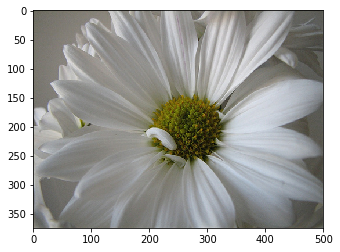

In [0]:
import numpy as np
import matplotlib.pyplot as plt 

plt.imshow(tf.image.decode_jpeg(all_tensors_images[np.random.randint(100)]).numpy())

### La méthode .map

Nous allons utiliser un modèle de Deep Learning InceptionV3 qui prend une taille d'image bien précise. Il sera bon de standardiser la taille de chacun de nos tenseurs.

Nous devrons ensuite pourvoir fitter cela dans un `tf.data` afin de le mettre dans un modèle. Pour cela nous allons devoir le faire en plusieurs étapes : 

1. Nous allons créer une fonction qui va preprocesser les images et les mettre à la bonne taille 
2. Nous créerons une instance de `tf.data`
3. Nous ferons un mapping du preprocessing dont nous avons besoin d'effectuer sur les images. 


In [0]:
# Création d'une fonction qui lit le chemin d'une image,
# décode l'image puis lui change sa taille.
def preprocess_and_load_images(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  return image

In [0]:
# Création d'une instance de Tf.data
ds_paths = tf.data.Dataset.from_tensor_slices(all_image_paths)
ds_images = ds_paths.map(preprocess_and_load_images)

Cette méthode `.map` n'est pas forcément pratique au premier abord. Celle-ci fonctionne de la même manière qu'on fonction `lambda`. Le but est d'appliquer sur chacune des images, la fonction que nous avons définie plus haut et que nous avons mis en argument de `.map`. 

Cette méthode est extrêmement pratique et s'utilise beaucoup dans l'univers Tensorflow. Plus d'informations ici : 

[map function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

In [0]:
# Regardons quelques exemples de notre dataset pour voir si tout est bon
for i,example in enumerate(ds_images):
  if i < 3:
    print(example)
  else:
    break

tf.Tensor(
[[[ 25.802084   16.         79.       ]
  [ 26.         16.         79.       ]
  [ 24.632812   16.632812   76.63281  ]
  ...
  [ 94.94105    90.96885   133.15111  ]
  [ 72.5        56.796143  101.541016 ]
  [ 79.65651    58.26063   100.047585 ]]

 [[ 26.         16.         78.796875 ]
  [ 25.533447   16.060303   78.879395 ]
  [ 22.         16.         78.       ]
  ...
  [ 50.291046   39.967884   99.26118  ]
  [ 68.454346   53.5459     99.27588  ]
  [ 72.07627    52.32473    97.10669  ]]

 [[ 26.         16.         76.16406  ]
  [ 25.         16.93335    77.1333   ]
  [ 22.         16.         78.       ]
  ...
  [ 57.785843   43.784134   95.13649  ]
  [ 65.092285   47.84375   100.30371  ]
  [ 68.82311    50.097713   92.35949  ]]

 ...

 [[ 15.652751    8.622722   40.824463 ]
  [ 45.166748   25.354248   80.7605   ]
  [ 49.697918   25.692627   85.41488  ]
  ...
  [ 29.813417   14.1640625  49.972195 ]
  [ 26.524902   16.02124    50.02124  ]
  [ 37.583965   24.990154   61.58

### Gestion des labels depuis un dossier 

A ce stage, nous avons un dataset d'images que nous avons converties en Tenseurs pour pouvoir les mettre dans notre modèle. Il nous manque cependant notre variable cible dont nous nous sommes pas occupée. 

Chacune des observations se trouvent dans le nom de chacun des sous-dossiers de `flower_photos`. Nous pouvons donc prendre les différents noms de classe de la manière suivante : 

In [0]:
labels = []
for data in data_root.iterdir():  # Boucle sur tous les éléments du dossier flower_photos
  if data.is_dir():               # Vérifie que l'élément soit un dossier
    labels += [data.name]         # On prend que le nom du dossier 

In [0]:
print(labels)

['daisy', 'tulips', 'sunflowers', 'dandelion', 'roses']


Une fois que nous avons les éléments du dossier, nous allons leur donner un index afin que nous ayons avoir des labels chiffrés. 

In [0]:
labels_index = {}
for i,label in enumerate(labels):
  labels_index[label]=i
  
print(labels_index)  

{'daisy': 0, 'tulips': 1, 'sunflowers': 2, 'dandelion': 3, 'roses': 4}


Enfin, nous devons créer une liste de la taille de notre dataset qui va donner le label de chacune des photos. 

In [0]:
all_image_labels = [labels_index[path.parent.name] for path in list(data_root.glob("*/*"))]

In [0]:
len(all_image_labels) == len(all_images)

True

Nous avons réussit à construire nos labels et l'avons vérifié puisque la taille de notre dataset de labels correspond à la taille de toutes nos images. Tentons de vérifier tout de même sur une vraie image. 

Text(0.5, 1.0, "index = 3, flower_name = ['dandelion']")

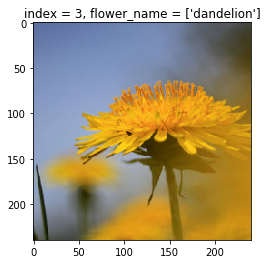

In [0]:
random_image = np.random.randint(len(all_image_labels))

plt.imshow(tf.image.decode_jpeg(all_tensors_images[random_image]).numpy())

plt.title("index = {}, flower_name = {}".format(all_image_labels[random_image], 
                                                [key for key, value in labels_index.items() if value == all_image_labels[random_image]]))

Il semblerait que tout soit bon ! On va donc pouvoir créer un dataset qui va mélanger les images ainsi que les labels 

In [0]:
# Nous créons un dataset pour nos labels 
labels_ds = tf.data.Dataset.from_tensor_slices(all_image_labels)

In [0]:
# Nous créons un dataset qui zip les deux premiers 
full_ds = tf.data.Dataset.zip((ds_images, labels_ds))

Regardons la tête de notre nouveau dataset :

In [0]:
next(iter(full_ds))

(<tf.Tensor: id=7379, shape=(192, 192, 3), dtype=float32, numpy=
 array([[[ 25.802084 ,  16.       ,  79.       ],
         [ 26.       ,  16.       ,  79.       ],
         [ 24.632812 ,  16.632812 ,  76.63281  ],
         ...,
         [ 94.94105  ,  90.96885  , 133.15111  ],
         [ 72.5      ,  56.796143 , 101.541016 ],
         [ 79.65651  ,  58.26063  , 100.047585 ]],
 
        [[ 26.       ,  16.       ,  78.796875 ],
         [ 25.533447 ,  16.060303 ,  78.879395 ],
         [ 22.       ,  16.       ,  78.       ],
         ...,
         [ 50.291046 ,  39.967884 ,  99.26118  ],
         [ 68.454346 ,  53.5459   ,  99.27588  ],
         [ 72.07627  ,  52.32473  ,  97.10669  ]],
 
        [[ 26.       ,  16.       ,  76.16406  ],
         [ 25.       ,  16.93335  ,  77.1333   ],
         [ 22.       ,  16.       ,  78.       ],
         ...,
         [ 57.785843 ,  43.784134 ,  95.13649  ],
         [ 65.092285 ,  47.84375  , 100.30371  ],
         [ 68.82311  ,  50.097713 ,  

Nous voyons bien que nous avons notre dataset avec les labels correspondant ! On est donc très bien parti pour lancer notre modèle. 

Passons maintenant à la partie Data Augmentation 

### Data Augmentation 

Cette fois, nous n'allons pas faire notre data augmentation sur des objets Numpy mais directement sur les images présentes dans le dossier *flower_photos*. 

Au lieu de passer par Keras, nous allons cette fois reprendre la méthode que nous avons utilisé plus haut avec la fonction `map`. Nous allons donc créer une fonction `augmentation` qui fera tout le travail d'augmentation puis nous maperons ceci sur nos données. 

In [0]:
def augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_crop(image, size=(192,192, 3))
  image = tf.image.random_brightness(image, max_delta=10)
  image = image /255.0

  return image, label

Dans la fonction d'augmentation, nous effectuons : 

1. Un effet mirroir horizontal sur les images 
2. Un rognage aléatoire 
3. Une différence de luminosité aléatoire 

Appliquons les sur notre dataset 

In [0]:
full_ds = full_ds.map(augmentation)

Passons une dernière couche de preprocessing où nous allons tout d'abord mélanger toutes les images puis nous transformerons notre dataset en batchs. 

Cela permettra à notre modèle de voir des images différentes par batch au lieu de voir chacun des labels de manière séquentielle. 

In [0]:
full_ds = full_ds.shuffle(len(all_images)).batch(10)

Regardons maintenant une image dans 3 batch différents. 

W0711 12:55:37.105186 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 12:55:37.134522 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 12:55:37.159840 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


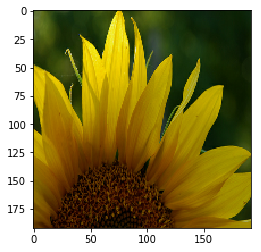

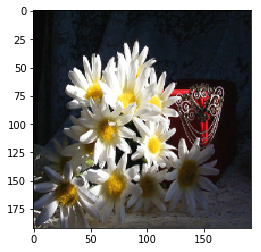

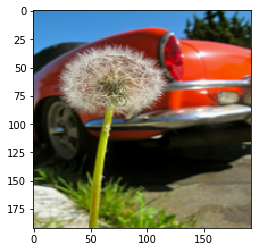

In [0]:
for example_x, example_y in full_ds.take(3):
  plt.figure()
  plt.imshow(example_x[0].numpy())
  
plt.show()  

## Transfer Learning 

### Import d'un modèle pré-entrainé 

Maintenant que nos images sont preprocessées, nous pouvons passer à la partie algorithmique. Nous allons nous occuper d'utiliser un modèle déjà existant : Inception_v3 et l'utiliser pour classer nos fleurs. Voici comment nous pouvons procéder

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape=(192,192,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87916544/87910968 [==============================] - 3s 0us/step


Ici, nous avons importé l'architecture à laquelle nous avons spécifier de na pas prendre la dernière couche d'output. En effet, cette couche sera adaptée à notre besoin de classification de fleurs. Ce modèle a été entrainé sur un nombre beaucoup plus conséquents d'images différentes. 

Regardons rapidement ce que donne l'architecture de notre modèle :

In [0]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 95, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Nous devons maintenant geler notre modèle pour n'entrainer que les dernières couches

In [0]:
base_model.trainable = False

Ceci empêche d'entrainer tout notre modèle. Ajoutons maintenant la dernière couche qui nous intéresse pour notre problématique 

### Adaptation du modèle au dataset

Lorsque nous avons importé notre modèle, nous avons enlevé la dernière couche pour pouvoir l'adapter à notre situation. Prenons donc maintenant la prochaine cellule de code pour ajouter notre dernière couche. 

Nous allons utiliser une couche `GlobalAveragePooling2D` qui va permettre de sortir les pixels les plus signifiants de l'image et une dernière couche `Dense` qui prendra le nombre de classes de notre dataset et une fonction d'activation `softmax` qui sortira des probabilités pour chacune des prédictions. 

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation="softmax")
])

Préparons notre fonction de coût, notre optimiser et un learning rate schedule pour améliorer nos résultats de prédictions et minimiser notre fonction de coût. 

In [0]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)


In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

Entrainons maintenant notre modèle.

In [0]:
model.fit(full_ds, epochs=5)

Epoch 1/5


W0711 12:56:11.808006 140702545442688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


367/367 [==============================] - 53s 143ms/step - loss: 0.9805 - sparse_categorical_accuracy: 0.6275
Epoch 2/5
367/367 [==============================] - 42s 116ms/step - loss: 0.6891 - sparse_categorical_accuracy: 0.7471
Epoch 3/5
367/367 [==============================] - 44s 119ms/step - loss: 0.6060 - sparse_categorical_accuracy: 0.7736
Epoch 4/5
367/367 [==============================] - 44s 119ms/step - loss: 0.5719 - sparse_categorical_accuracy: 0.7877
Epoch 5/5
367/367 [==============================] - 42s 115ms/step - loss: 0.5366 - sparse_categorical_accuracy: 0.8057


Nos résultats ne sont pas mauvais déjà ! Nous pouvons cependant tenter de continuer d'entrainer notre modèle mais cette fois en libérant quelque couche. C'est ce qu'on appelle faire du _fine tuning_. Nous allons donc débloquer les 75 dernières couches du modèle. 

In [0]:
base_model.trainable = True
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Retentons d'entrainer le modèle. 

In [0]:
# Vous devrez refaire tourner un model.compile avant de ré-entrainer le modèle 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])


model.fit(full_ds, epochs=15)

Epoch 1/15
367/367 [==============================] - 202s 550ms/step - loss: 0.7626 - sparse_categorical_accuracy: 0.7305
Epoch 2/15
367/367 [==============================] - 102s 277ms/step - loss: 0.4914 - sparse_categorical_accuracy: 0.8218
Epoch 3/15
367/367 [==============================] - 101s 276ms/step - loss: 0.4407 - sparse_categorical_accuracy: 0.8480
Epoch 4/15
367/367 [==============================] - 102s 278ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8665
Epoch 5/15
367/367 [==============================] - 102s 278ms/step - loss: 0.3185 - sparse_categorical_accuracy: 0.8858
Epoch 6/15
367/367 [==============================] - 102s 277ms/step - loss: 0.2321 - sparse_categorical_accuracy: 0.9185
Epoch 7/15
367/367 [==============================] - 103s 280ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9526
Epoch 8/15
367/367 [==============================] - 103s 280ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9455
Epoch 9/15
367/3

Nous arrivons à des résultats très satisfaisants ! Nous n'avons pas de dataset de validation donc il nous sera difficile de vérifier l'overfitting. Regardons cependant une prédiction sur un batch de données d'entrainement.

In [0]:
# nous créons une liste de prédictions pour tout le dataset 
y_pred = [np.argmax(model.predict_on_batch(pred),1) for pred in full_ds.take(-1)]

In [0]:
# Convertissons chacune des prédictions en listes plutôt qu'en numpy array
y_pred = [list(y) for y in y_pred]

W0711 13:27:45.209112 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.265240 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.288729 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.310928 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.335491 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.358018 140702545442688 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0711 13:27:45.380619 140702

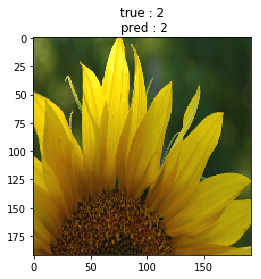

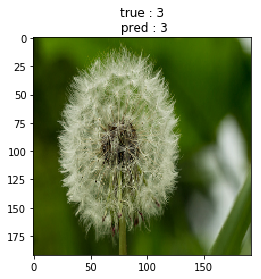

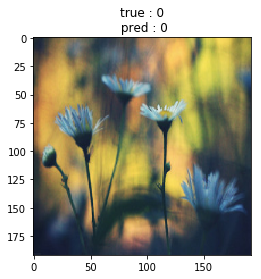

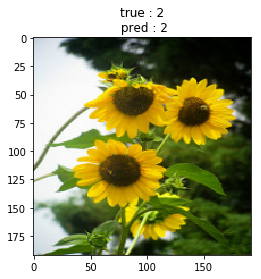

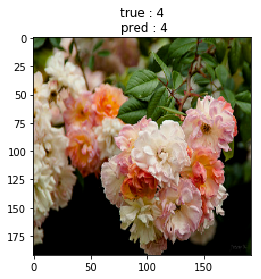

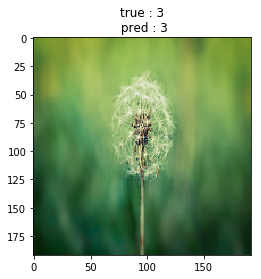

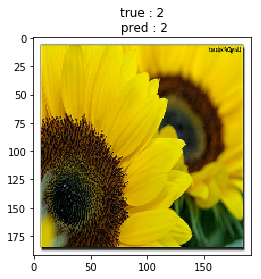

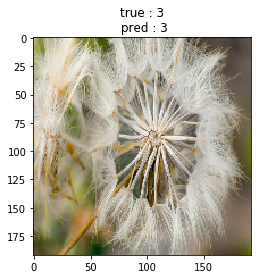

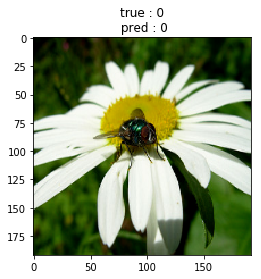

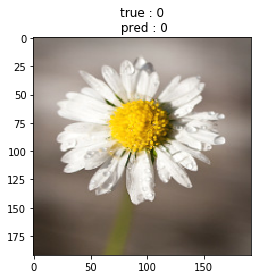

In [0]:
# Visualisons les 10 images du batch 
for x, y in full_ds.take(1):
  for i in range(len(y)):
    plt.figure()
    plt.imshow(x.numpy()[i])
    plt.title("true : {}\n pred : {}".format(y.numpy()[i], y_pred[0][i]))
plt.show()

Sur les 10 images de ce batch, nous avons 1 seule erreur. Les résultats sont donc très satisfaisants ! 

## Visualiser le processus d'apprentissage

Pour visualiser le processus d'apprentissage, il vous faudra stocker l'apprentissage de votre modèle dans une variable 

In [0]:
history = model.fit(full_ds, epochs=5)

Epoch 1/5
367/367 [==============================] - 104s 282ms/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9807
Epoch 2/5
367/367 [==============================] - 103s 281ms/step - loss: 0.0643 - sparse_categorical_accuracy: 0.9779
Epoch 3/5
367/367 [==============================] - 103s 280ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9896
Epoch 4/5
367/367 [==============================] - 102s 278ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9864
Epoch 5/5
367/367 [==============================] - 102s 279ms/step - loss: 0.1119 - sparse_categorical_accuracy: 0.9597


Une fois ceci fait, vous obtenez à l'intérieur de _history_ un dictionnaire de valeur que vous pouvez accéder de la façon suivante : 

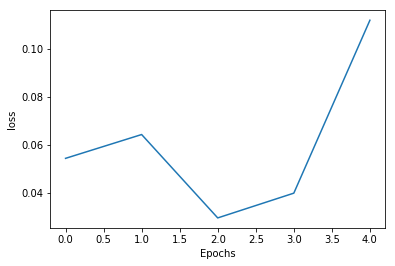

In [0]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

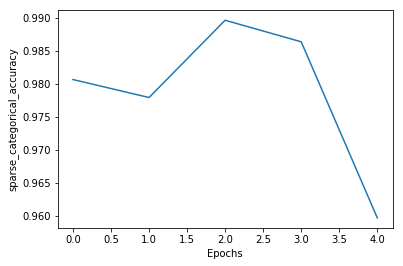

In [0]:
plt.plot(history.history["sparse_categorical_accuracy"])
plt.ylabel("sparse_categorical_accuracy")
plt.xlabel("Epochs")
plt.show()

## Ressources

* [Load Images with Tf.Data](https://www.tensorflow.org/beta/tutorials/load_data/images)
* [Transfer Learning using pre-trained ConvNets](https://www.tensorflow.org/beta/tutorials/images/transfer_learning)
* [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)